In [50]:
import pygad
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.linalg as la
import itertools

In [51]:
def ArranjoTriangular(alpha, beta, gama):
    """
    Retorna a matriz triangular A com parâmetros alpha, beta e gamma.
    complex(x, y) retorna um número complexo da forma x + yi, onde i é o número imaginário
    
    Parâmetros
    --------------------------------------
    :params alpha, beta, gama: alpha é um número real
    
    Retorno
    --------------------------------------
    :return: retorna a matriz arranjo triangular como numpy array cujos valores estão de acordo com os parâmetros recebidos
    """
    A = np.array([[0, complex(0, gama), complex(0, beta)], 
                  [complex(0, gama), 0, complex(0, alpha)], 
                  [complex(0, beta), complex(0, alpha), 0]])
    
    return A

In [52]:
def MatrizTransferenciaTriangular(A, z):
    """
    Retorna a matriz de transferência triangular T a partir de uma matriz de arranjo triangular A a partir dos passos já citados
    Erro percentual de 10^(-14) a 10^(-16), ínfimo.
    
    Parâmetros
    --------------------------------------
    :param A: matriz de Arranjo Triangular como numpy array
    :param z: número real qualquer (comprimento do acoplador)
    
    Retorno
    
    :return:  matriz numpy array de transferência triangular T calculada com erro ínfimo.
    """
    eigvals, eigvecs = la.eig(A)
    D = np.array([[eigvals[0], 0, 0], 
                  [0, eigvals[1], 0], 
                  [0, 0, eigvals[2]]])
    P = eigvecs.copy()
    E = np.array([[np.exp(z*eigvals[0]), 0, 0], 
                  [0, np.exp(z*eigvals[1]), 0], 
                  [0, 0, np.exp(z*eigvals[2])]])
    
    if np.allclose(A, P @ D @ la.inv(P), atol=1e-17):
        raise ValueError(f'Parameter Matrix A has not property A == PDP^(-1) for a tolerance of {1e-17}')
    
    # T é a matriz de transferência
    T = P @ E @ la.inv(P)
    
    return T

In [53]:
def Tv(NumberOfInputs):
    """
    Retorna uma tabela verdade (TruthTable) dado um circuito com n inputs maiores ou iguais a 1
    Checa se a variável NumberOfInputs é inteira. Se sim, continua normalmente, se não lança uma exceção com a mensagem
    'Parameter \'NumberOfInputs\' must be a integer'

    Parâmetros
    ------------------------------------------------
    :param NumberOfInputs: número de inputs do circuito lógico, deve ser um número inteiro (obrigatoriamente)
    
    Retorno
    ------------------------------------------------
    :return: Retorna a tabela verdade como uma lista do Python (caso necessário, transformar o retorno em numpy array)
    """
    if not isinstance(NumberOfInputs, int):
        raise ValueError('Parameter \'NumerOfInputs\' must be a integer')
    if NumberOfInputs < 1:                                                   
        raise ValueError('Parameter \'NumberOfInputs\' must be greater or equal to 1')
    else:
        table = list(itertools.product ([0, 1], repeat = NumberOfInputs))    
        table = np.array(table, dtype=float)
        return table

In [54]:
def PAM(TruthTable, epsilon):
    """
    Função que retorna uma modulação PAM para uma dada tabela verdade (TruthTable) e certo epsilon real arbitrário.
    Não modifica a tabela verdade original, apenas realiza alterações em uma cópia e a retorna no final.
    Funciona para qualquer tabela verdade (TruthTable) com n inputs (Matriz não precisa ser quadrada)

    Parâmetros
    ------------------------------------------------
    :param TruthTable: tabela verdade a ser analisada e transformada em modulação PAM
    :param epsilon: epsilon no qual os valores serão calculados
    
    Retorno
    ------------------------------------------------
    :return: retorna um numpy array como matriz da modulação PAM da tabela verdade recebida como parâmetro
    """
    if epsilon <= 0 or epsilon >= 1:
        raise ValueError(f'Epsilon must be major than 0 and minor than 1')
    PamTable = TruthTable.copy() # Como utiliza uma cópia, PamTable será uma matriz com elementos do tipo float
    rows, columns = PamTable.shape
    for row in range(rows):
        for column in range(columns):
            if PamTable[row][column] == 1:
                PamTable[row][column] = 1 + epsilon
            elif PamTable[row][column] == 0:
                PamTable[row][column] = 1 - epsilon
            else:
                raise ValueError('Truth Table must be filled just with zeros and ones')
    return PamTable

In [55]:
def InvPAM(PAMTable):
    """
    Função que retorna uma nova tabela verdade com modulação bniária (processo inverso da modulação PAM)
    
    Parâmetros
    ------------------------------
    :param PAMTable: Tabela verdade em modulação PAM (1 +- epsilon)
    
    Retorno
    ------------------------------
    :return: Retorna uma nova matriz como numpy array que representa a tabela verdade original (inversa da PAM)
    """
    rows, columns = PAMTable.shape
    ResultTable = np.ones(shape=(rows, columns), dtype=float)
    for row in range(rows):
        for column in range(columns):
            if PAMTable[row][column] < 1:
                ResultTable[row][column] = 0
    return ResultTable

In [56]:
target = AndTruthTableGenerator(Tv(3))
solution = []
def AptidaoArranjoTriangular(solution, solution_idx):
    A = ArranjoTriangular(solution[0], solution[1], solution[2])
    T = MatrizTransferenciaTriangular(A, solution[3])
    Inp = PAM(Tv(3), 0.010)
    Out = T @ Inp.T
    Out = Out.T
    OutPAM = PAM(target, 0.010)
    
    Out1 = np.array([Out[:,0]])
    Out1 = Out1.T
    kernel = math.e**(-np.linalg.norm(20*np.log10(OutPAM) - 20*np.log10(abs(Out1))))
    
    return kernel

In [57]:
def OrTruthTableGenerator(TruthTable):
    """
    Retorna uma tabela verdade do circuito lógico OR de acordo com uma tabela verdade (TruthTable). 
    Checa se a tabela está vazia, se sim a retorna (vazia), se não, realiza os cálculos.
    
    Parâmetros
    ------------------------------------------------
    :param TruthTable: tabela verdade a ser analisada
    
    Retorno
    ------------------------------------------------
    :return: Retorna a coluna (numpy array) com os valores da tabela verdade OR dos inputs da tabela verdade recebida 
    como parâmetro
    """
    rows, columns = TruthTable.shape
    ResultTable = np.zeros(shape=(rows, 1), dtype=float)
    
    if TruthTable.size == 0:
        return TruthTable
    
    for row in range(rows):
        BooleanRowArray = TruthTable[row][:]
        if np.any(BooleanRowArray):
            ResultTable[row][0] = 1
        
    return ResultTable

In [58]:

def AndTruthTableGenerator(TruthTable):
    """
    Retorna uma tabela verdade do circuito lógico AND de acordo com uma tabela verdade (TruthTable). 
    Checa se a tabela está vazia, se sim a retorna (vazia), se não, realiza os cálculos.
    
    Parâmetros
    ------------------------------------------------
    :param TruthTable: tabela verdade a ser analisada
    
    Retorno
    ------------------------------------------------
    :return: Retorna a coluna (numpy array) com os valores da tabela verdade AND dos inputs da tabela verdade recebida 
    como parâmetro
    """
    rows, columns = TruthTable.shape
    ResultTable = np.zeros(shape=(rows, 1), dtype=float)
    
    if TruthTable.size == 0:
        return TruthTable
    
    for row in range(rows):
        BooleanRowArray = TruthTable[row][:]
        if np.all(BooleanRowArray):
            ResultTable[row][0] = 1;
    
    return ResultTable

# Implementação do Algoritmo Genético no PyGad no nosso código

Já temos a função de aptidão, na qual depende do resultado de outras funções e retorna um valor de kernel. Nossa solução deve gerar um kernel obtido dessa função o mais próximo de 1 quanto possível, quando as relações de contraste de OutPAM e Out1 são o mais próximas possível.

Utilizaremos uma variação da função de aptidão, dada por: 

$$f(\alpha, \beta, \gamma, z) = e^{-|20\dot log_{10}{OutPAM} - 20\dot log_{10}{Out1}|}$$

In [59]:
fitness_function = AptidaoArranjoTriangular

num_generations = 500
num_parents_mating = 4

sol_per_pop = 10
num_genes = 4

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

In [60]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=AptidaoArranjoTriangular,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

In [61]:
ga_instance.run()

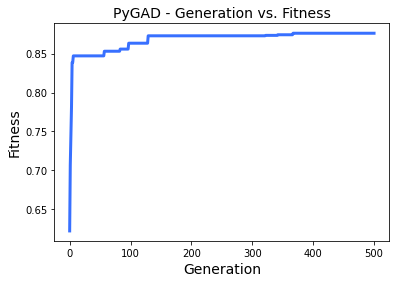

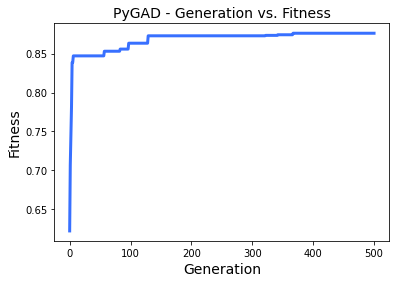

In [62]:
ga_instance.plot_fitness()

In [63]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

Parameters of the best solution : [ 2.66673577  0.10661816 -3.34207077  1.84177625]
Fitness value of the best solution = 0.8761591723868707
Index of the best solution : 0


In [64]:
if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

Best fitness value reached after 367 generations.
